# Sentiment classification of TV reviews using ReLU  
Sentiment analysis of "[Tatort](https://en.wikipedia.org/wiki/Tatort)" Reviews.  
Data source: Facebook comments pulled from weekly 'poll' postings on the 'dasErste' FB page.

1 = positive review  
2 = negative review

## Import and review the data

In [154]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tflearn
from tflearn.data_utils import to_categorical, pad_sequences
import matplotlib.pyplot as plt

tatortreviews = pd.read_csv('data/tatort_reviews_labeled.csv')
print("Number of training reviews: ", len(tatortreviews))

tatortreviews_new = pd.read_csv('data/tatort_reviews_new.csv')
print("Number of new reviews: ", len(tatortreviews_new))

tatortreviews.head()

Number of training reviews:  2257
Number of new reviews:  257


,Review,Evalu
0,schlechteste ever 😣,0
1,6 absolut kein thema mehr,0
2,"ein sehr guter tatort (y), das franken-team so...",1
3,absolute 6!,0
4,"kann nicht mitreden. ""x-men: apocalypse"" auf s...",0


In [155]:
reviews = tatortreviews['Review']
labels = tatortreviews['Evalu']

new_reviews = tatortreviews_new['Review']

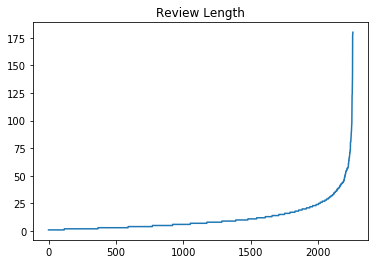

In [156]:
%matplotlib inline

review_lengths = []
for review in reviews:
    review_lengths.append(len(review.split(' ')))
plt.figure()
plt.title('Review Length')
plt.plot(sorted(review_lengths))

#### Bag of Words

In [157]:
from collections import Counter

total_wordcount = Counter()

for row in reviews:
    total_wordcount.update(row.split(" "))
    
print("Total word count: ", len(total_wordcount))

Total word count:  6393


In [158]:
vocabulary = sorted(total_wordcount, key=total_wordcount.get, reverse=True)[:6370]
vocabulary = vocabulary[20:]
    
print("Num of words: ", len(vocabulary))
for x in range(0, 10):
    print(vocabulary[x])

Num of words:  6350
mir
so
auch
in
note
hat
ist
von
super
für


In [159]:
wordindex = {word: i for i, word in enumerate(vocabulary)}

print(wordindex.get('spannend'))
print(wordindex.get('doof'))

13
1501


## Mapping text to vector

In [160]:
def text_to_vector(text):
    word_vector = np.zeros(len(vocabulary), dtype = np.int_)
    for word in text.split(' '):
        idx = wordindex.get(word, None)
        if idx is None:
            continue
        else:
            word_vector[idx] += 1
    return np.array(word_vector)
 
word_vectors = np.zeros((len(reviews), len(vocabulary)), dtype=np.int_)    
for ii, text in enumerate(reviews):
    word_vectors[ii] = text_to_vector(text)

### Split data into Train, Validation, Test sets

In [161]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, Y_train, Y_test = train_test_split(reviews, labels, test_size=0.1, random_state=666)

#print(len(X_train))
#print(len(Y_train))

Y = labels
records = len(labels)

shuffle = np.arange(records)
np.random.shuffle(shuffle)
test_fraction = 0.9

train_split, test_split = shuffle[:int(records*test_fraction)], shuffle[int(records*test_fraction):]
X_train, Y_train = word_vectors[train_split], to_categorical(Y.values[train_split], 2)
X_test, Y_test = word_vectors[test_split], to_categorical(Y.values[test_split], 2)

## Building the network

In [162]:
def build_network_model():
    tf.reset_default_graph()
    
    #Inputs
    net = tflearn.input_data([None, 6350])
    
    #Hidden layer
    net = tflearn.fully_connected(net, 120, activation='relu')
    
    #Output Layer
    net = tflearn.fully_connected(net, 2, activation='softmax')
    net = tflearn.regression(net, optimizer='sgd', learning_rate=0.09, loss='categorical_crossentropy')
    
    model = tflearn.DNN(net)
    return model


# Now, build it!
model = build_network_model()

## Training the network


In [163]:
model.fit(X_train, Y_train, validation_set = 0.1, show_metric=True, batch_size=200, n_epoch=100)

Training Step: 999  | total loss: 0.20216 | time: 0.154s
| SGD | epoch: 100 | loss: 0.20216 - acc: 0.9521 -- iter: 1800/1827
Training Step: 1000  | total loss: 0.19995 | time: 1.165s
| SGD | epoch: 100 | loss: 0.19995 - acc: 0.9544 | val_loss: 0.36335 - val_acc: 0.8088 -- iter: 1827/1827
--


## Testing 

In [164]:
predictions = (np.array(model.predict(X_test)) >= 0.5).astype(np.int_)
test_accuracy = np.mean(predictions == Y_test, axis=0)
print("Test accuracy: ", test_accuracy)

Test accuracy:  [ 0.78761062  0.78761062]


In [165]:
# Check with a custom sentence.
# res = the result of the prediction, containing the positive and negative probability.
res = model.predict([text_to_vector("ein spannender film")])[0]
print(res)
if(res[1] > res[0]):
    print('Positiv!')
else:
    print('Negativ!')

[0.09177649021148682, 0.9082234501838684]
Positiv!


## Predicting New Reviews

In [166]:
for index, row in tatortreviews_new.iterrows():
    res = model.predict([text_to_vector(row['Review'])])[0]
    if(res[1] > res[0]):
        tatortreviews_new.loc[index, 'Evalu'] = 1
    else:
        tatortreviews_new.loc[index, 'Evalu'] = 0
        
tatortreviews_new.to_csv(index = False, path_or_buf = 'data/tatortreviews_new_prediction.csv')



## Comparing with Corrected Review Evaluations
(before running this step, a manual step is needed to review the predictions, and update incorrect evaluations in data/tatortreviews_new_prediction_corrected.csv

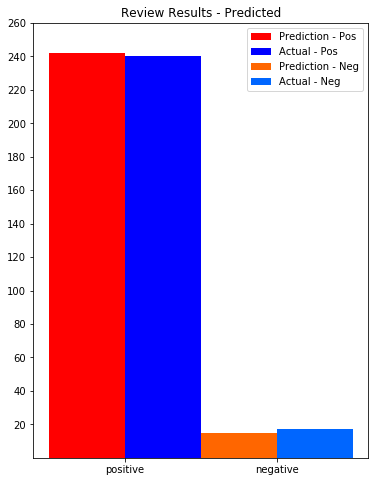

In [270]:
%matplotlib inline
import collections

tatortreviews_new_corrected = pd.read_csv('data/tatortreviews_new_prediction_corrected.csv')
count_tatortreviews_new_corrected = collections.Counter(tatortreviews_new_corrected['Evalu'])
count_tatortreviews_new = collections.Counter(tatortreviews_new['Evalu'])
plt.figure(figsize=(6, 8), facecolor='w', edgecolor='k')
plt.title('Review Results - Predicted')
index = np.arange(1)
bar_width = 1
opacity = 1
pred_pos = plt.bar(index, count_tatortreviews_new[1], bar_width,
                 alpha=opacity,
                 color='#ff0000',
                 label='Prediction - Pos')

corr_pos = plt.bar(index + bar_width, count_tatortreviews_new_corrected[1], bar_width,
                 alpha=opacity,
                 color='#0000ff',
                 label='Actual - Pos')

pred_neg = plt.bar(index + (bar_width * 2) , count_tatortreviews_new[0], bar_width,
                 alpha=opacity,
                 color='#ff6600',
                 label='Prediction - Neg')

corr_neg = plt.bar(index + (bar_width * 3), count_tatortreviews_new_corrected[0], bar_width,
                 alpha=opacity,
                 color='#0066ff',
                 label='Actual - Neg')

plt.legend()

labels = ['positive', 'negative']
plt.xticks([index + bar_width / 2, (bar_width * 3) - (bar_width / 2) ] , labels)
plt.yticks([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260])
plt.show()